In [1]:
import os

# Change directory to your target path
os.chdir('/Users/carolinarutilidelima/Documents/OD_Sao_Paulo/')


#os.chdir("/home/carolima/Documents/GitHub/OD_Sao_Paulo/")

In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = './output_data/df_with_distances.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to confirm it was loaded correctly
df.head()

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,source_location,destination_location,distance_km
0,337,62,1,23,16,19,2841.83,378.87,2817.97,1.14,Parque Continental,Parque Ibirapuera,10.845722
1,25,101,1,1,19,0,1185.44,406.94,1127.68,1.36,Treze de Maio,Vila Ipojuca,6.822359
2,88,152,2,16,0,7,1352.46,251.30,1330.74,1.19,Perdizes,Parada Inglesa,9.691765
3,24,111,1,1,19,0,1303.00,333.09,1263.41,1.28,Liberdade,São Domingos,13.187786
4,11,241,1,1,19,0,1449.89,289.63,1423.34,1.21,Bom Jardim,Vila Independência,6.100247


In [3]:
import json

# Load the JSON file with the MOVEMENT_ID and location names
json_file_path = './input_data/od_sp.json'

# Read the JSON data
with open(json_file_path, 'r') as file:
    location_data = json.load(file)

# Extract the mapping between MOVEMENT_ID and location names
movement_id_to_name = {int(feature['properties']['MOVEMENT_ID']): feature['properties']['DISPLAY_NAME'] for feature in location_data['features']}

# Now replace sourceid and dstid with their corresponding location names in the dataframe
df['source_location'] = df['sourceid'].map(movement_id_to_name)
df['destination_location'] = df['dstid'].map(movement_id_to_name)
# Now replace sourceid and dstid with their corresponding location names in the dataframe
df['source_location'] = df['sourceid'].map(movement_id_to_name)
df['destination_location'] = df['dstid'].map(movement_id_to_name)

df[['sourceid', 'source_location', 'dstid', 'destination_location']].head()


,sourceid,source_location,dstid,destination_location
0,337,Parque Continental,62,Parque Ibirapuera
1,25,Treze de Maio,101,Vila Ipojuca
2,88,Perdizes,152,Parada Inglesa
3,24,Liberdade,111,São Domingos
4,11,Bom Jardim,241,Vila Independência


In [4]:

# Filter pairs that have more than 30 km between them
pairs_30km_plus = df[df['distance_km'] >= 30].sort_values(by='distance_km', ascending=False)


In [5]:
pairs_30km_plus

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,source_location,destination_location,distance_km
5653947,399,516,2,10,10,16,6030.88,1224.64,5924.16,1.20,Pinheirinho,Santana de Parnaíba,80.783063
11825799,516,399,2,10,10,16,7250.00,755.85,7210.14,1.11,Santana de Parnaíba,Pinheirinho,80.783063
6687811,516,401,2,10,10,16,6942.67,743.53,6902.47,1.11,Santana de Parnaíba,Suzano,80.559507
532107,401,516,2,10,10,16,5667.00,1216.65,5556.60,1.21,Suzano,Santana de Parnaíba,80.559507
4992364,400,516,2,10,10,16,5812.38,1221.75,5703.14,1.21,Miguel Badra,Santana de Parnaíba,80.464699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13773910,374,405,2,25,19,0,2322.33,267.80,2305.55,1.13,Aeroporto,Estudantes,30.006975
988048,405,374,2,12,10,16,2193.33,343.00,2166.28,1.17,Estudantes,Aeroporto,30.006975
1519542,374,405,1,18,19,0,2394.27,211.04,2385.25,1.09,Aeroporto,Estudantes,30.006975
12842497,82,229,1,31,19,0,4246.00,319.66,4233.84,1.08,Pinheiros,Cidade Tiradentes,30.002409


In [6]:


def calculate_polygon_centroid(coords):
    """ Calculate the centroid from a list of coordinates that form a polygon. """
    x_coords = [p[0] for p in coords[0]]  # Assuming the first element of coords contains the polygon
    y_coords = [p[1] for p in coords[0]]
    _len = len(coords[0])
    centroid_x = sum(x_coords) / _len
    centroid_y = sum(y_coords) / _len
    return (centroid_x, centroid_y)

def process_json_data(json_file):
    # Load JSON data from file
    with open(json_file, 'r') as file:
        json_data = json.load(file)

    centroids = []
    # Extract data from JSON
    for feature in json_data['features']:
        if feature['geometry']['type'] == 'Polygon':
            coords = feature['geometry']['coordinates']
            centroid = calculate_polygon_centroid(coords)
            centroids.append({
                'MOVEMENT_ID': feature['properties']['MOVEMENT_ID'],
                'centroid_x': centroid[0],
                'centroid_y': centroid[1],
                'display_name': feature['properties']['DISPLAY_NAME']
            })

    # Convert to DataFrame
    centroids_df = pd.DataFrame(centroids)
    return centroids_df

# Replace 'path_to_json_file.json' with the actual path to the JSON file
centroids_df = process_json_data('./input_data/od_sp.json')
print(centroids_df)


    MOVEMENT_ID  centroid_x  centroid_y           display_name
0             1  -46.632705  -23.548821                     Sé
1             2  -46.629871  -23.546265       Parque Dom Pedro
2             3  -46.633489  -23.553232      Praça João Mendes
3             4  -46.641333  -23.551062     Ladeira da Memória
4             5  -46.642298  -23.544895              República
..          ...         ...         ...                    ...
511         513  -46.994807  -23.574907   Quatro Encruzilhadas
512         514  -46.928830  -23.542830                Itapevi
513         515  -46.969978  -23.542296           Amador Bueno
514         516  -46.912371  -23.443165    Santana de Parnaíba
515         517  -46.981213  -23.373727  Pirapora do Bom Jesus

[516 rows x 4 columns]


In [7]:
# Assuming 'original_df' is your DataFrame loaded from the CSV or data source
# and 'centroids_df' is the DataFrame we have processed

# Convert MOVEMENT_ID to the same type as 'sourceid' and 'dstid' in the original dataframe
centroids_df['MOVEMENT_ID'] = centroids_df['MOVEMENT_ID'].astype(str)  # or .astype(int) based on your original DataFrame

# Rename columns for source and destination merging
source_centroids = centroids_df.rename(columns={'centroid_x': 'source_x', 'centroid_y': 'source_y'})
destination_centroids = centroids_df.rename(columns={'centroid_x': 'dest_x', 'centroid_y': 'dest_y'})

# Also, ensure your 'sourceid' and 'dstid' are of type string if your MOVEMENT_ID is now string
pairs_30km_plus['sourceid'] = pairs_30km_plus['sourceid'].astype(str)
pairs_30km_plus['dstid'] = pairs_30km_plus['dstid'].astype(str)

# Merge on 'sourceid'
merged_df = pd.merge(pairs_30km_plus, source_centroids, how='left', left_on='sourceid', right_on='MOVEMENT_ID')
# Merge on 'dstid'
merged_df = pd.merge(merged_df, destination_centroids, how='left', left_on='dstid', right_on='MOVEMENT_ID')

# Optionally drop the extra MOVEMENT_ID columns if they are no longer needed
merged_df.drop(columns=['MOVEMENT_ID_x', 'MOVEMENT_ID_y'], inplace=True)

# Display the result to verify correctness
print(merged_df.head())


  sourceid dstid  month  day  start_hour  end_hour  mean_travel_time  \
0      399   516      2   10          10        16           6030.88   
1      516   399      2   10          10        16           7250.00   
2      516   401      2   10          10        16           6942.67   
3      401   516      2   10          10        16           5667.00   
4      400   516      2   10          10        16           5812.38   

   standard_deviation_travel_time  geometric_mean_travel_time  \
0                         1224.64                     5924.16   
1                          755.85                     7210.14   
2                          743.53                     6902.47   
3                         1216.65                     5556.60   
4                         1221.75                     5703.14   

   geometric_standard_deviation_travel_time      source_location  \
0                                      1.20          Pinheirinho   
1                                      1

In [8]:
# Assuming merged_df is your current DataFrame with the merged data
coordinates_df = merged_df[['source_x', 'source_y', 'dest_x', 'dest_y']]



# Option 2: Using concat (more control over layout)
# Create two DataFrames for source and destination, then concatenate them vertically
source_df = coordinates_df[['source_x', 'source_y']].rename(columns={'source_x': 'x', 'source_y': 'y'})
dest_df = coordinates_df[['dest_x', 'dest_y']].rename(columns={'dest_x': 'x', 'dest_y': 'y'})

# Add an identifier if needed to distinguish between source and dest
source_df['type'] = 'source'
dest_df['type'] = 'destination'

# Concatenate the dataframes
stacked_df = pd.concat([source_df, dest_df], ignore_index=True)
print(stacked_df.head())


           x          y    type
0 -46.302677 -23.464920  source
1 -46.912371 -23.443165  source
2 -46.912371 -23.443165  source
3 -46.308475 -23.567806  source
4 -46.300474 -23.507278  source


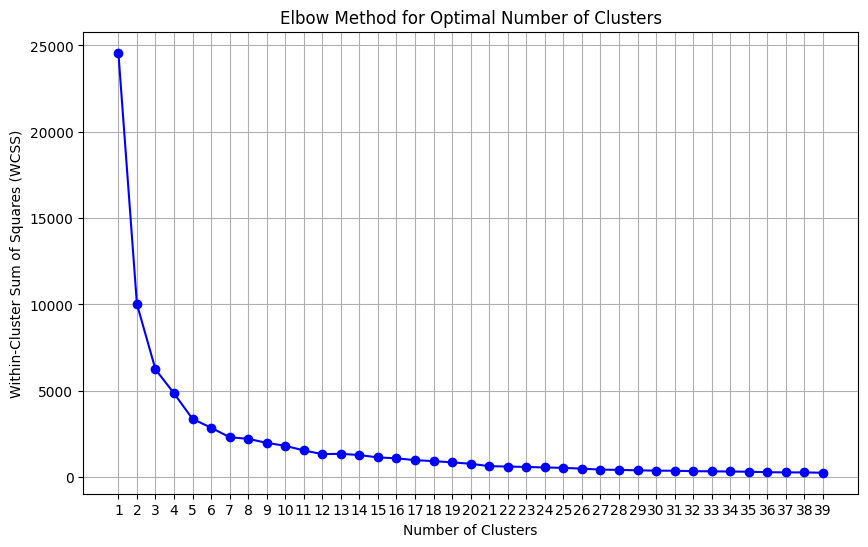

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Ensure the coordinates data is prepared
coordinates = stacked_df[['x', 'y']].dropna().values

# Range of clusters to test
cluster_range = range(1, 40)  # Testing from 1 to 30 clusters
wcss = []

# Calculate WCSS for each cluster count
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(coordinates)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


In [10]:
from sklearn.cluster import KMeans

# Assuming 'stacked_df' is the DataFrame containing stacked source and destination coordinates
coordinates = stacked_df[['x', 'y']].dropna().values  # Make sure data is clean without NaNs


# Setup K-Means with 30 clusters
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(coordinates)

# Retrieve the cluster centers
centers = kmeans.cluster_centers_


In [11]:
import folium
import numpy as np

# Initialize the map centered at the average location
map_centers = folium.Map(location=[np.mean(coordinates[:, 1]), np.mean(coordinates[:, 0])], zoom_start=12)

# Use a distinct color for the centers
center_color = "#ff0000"  # Red color for visibility

# Add each center to the map
for center in centers:
    folium.CircleMarker(
        [center[1], center[0]],  # Center coordinates (latitude, longitude)
        radius=7,
        color=center_color,
        fill=True,
        fill_color=center_color,
        fill_opacity=1,
        popup='Cluster Center'
    ).add_to(map_centers)

# Save or display the map
map_centers.save('ML study/KMeans_30_Centers_Map.html')


In [12]:
# Load the Excel file
file_path = './input_data/REH.xlsx'
excel_data = pd.ExcelFile(file_path)

# Display sheet names to understand the structure of the file
sheet_names = excel_data.sheet_names
sheet_names

['Sheet1']

In [13]:

data = pd.read_excel(file_path, sheet_name='Sheet1')


print("total", len(data))
data.head(3)

total 251


,station ID,route_number,route_name,lon,lat,max_alt
0,1,1,aproximacao17,-46.671667,-23.526946,3600
1,2,1,aproximacao17,-46.715833,-23.525280,3600
2,3,1,aproximacao17,-46.761668,-23.552225,3600


In [14]:

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  # Radius of earth in kilometers
    return c * r


In [15]:
closest_points = []

for center in centers:
    # Extract center coordinates
    center_lon, center_lat = center
    
    # Calculate distances from this center to all points in the dataset
    distances = data.apply(lambda row: haversine(center_lon, center_lat, row['lon'], row['lat']), axis=1)
    
    # Find the index of the minimum distance
    min_idx = distances.idxmin()
    
    # Append the closest point data to the list
    closest_points.append(data.loc[min_idx])

# Convert list to DataFrame
closest_points_df = pd.DataFrame(closest_points)


In [16]:
print(closest_points_df)


     station ID  route_number           route_name        lon        lat  \
109         110             8       rota_ecologico -46.510920 -23.478594   
171         172            20           rota_oeste -46.737063 -23.642779   
27           28             4  rota_anhanguera_sul -46.764421 -23.494149   
231         232            24           rota_senna -46.327400 -23.447804   
11           12             2        rota_anchieta -46.542100 -23.737514   
244         245            25          rota_suzano -46.185475 -23.515944   
83           84             5         rota_castelo -46.859987 -23.505072   
240         241            25          rota_suzano -46.301880 -23.535974   
156         157            18           rota_marte -46.621930 -23.539144   
202         203            22        rota_rodoanel -46.830605 -23.648440   
230         231            24           rota_senna -46.354180 -23.467274   
114         115             9       rota_espraiada -46.669118 -23.633616   
194         

In [17]:
df_no_duplicates = closest_points_df.drop_duplicates()
df_no_duplicates

,station ID,route_number,route_name,lon,lat,max_alt
109,110,8,rota_ecologico,-46.510920,-23.478594,3000
171,172,20,rota_oeste,-46.737063,-23.642779,3300
27,28,4,rota_anhanguera_sul,-46.764421,-23.494149,3200
231,232,24,rota_senna,-46.327400,-23.447804,3300
11,12,2,rota_anchieta,-46.542100,-23.737514,3300
244,245,25,rota_suzano,-46.185475,-23.515944,3300
83,84,5,rota_castelo,-46.859987,-23.505072,3200
240,241,25,rota_suzano,-46.301880,-23.535974,3300
156,157,18,rota_marte,-46.621930,-23.539144,3100
202,203,22,rota_rodoanel,-46.830605,-23.648440,3200


In [37]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

def calculate_distance(row1, row2):
    """Calculate the distance between two points given their latitude and longitude."""
    coords_1 = (row1['lat'], row1['lon'])
    coords_2 = (row2['lat'], row2['lon'])
    return geodesic(coords_1, coords_2).kilometers

def calculate_midpoint(row1, row2):
    """Calculate the midpoint between two geographical points."""
    mid_lat = (row1['lat'] + row2['lat']) / 2
    mid_lon = (row1['lon'] + row2['lon']) / 2
    return mid_lat, mid_lon

# Sort the dataframe by station ID (or any column you prefer)
closest_points_df = closest_points_df.sort_values(by="station ID").reset_index(drop=True)

# Track rows to delete and midpoints to add
rows_to_delete = set()
midpoints = []

# Loop through all rows to calculate distances
for i in range(len(closest_points_df)):
    if i in rows_to_delete:  # Skip if the station is already marked to be removed
        continue
    for j in range(i + 1, len(closest_points_df)):
        if j in rows_to_delete:  # Skip if the station is already marked to be removed
            continue
        distance = calculate_distance(closest_points_df.iloc[i], closest_points_df.iloc[j])
        if distance < 5:  # Distance threshold in kilometers
            # Mark both stations for removal
            rows_to_delete.add(i)
            rows_to_delete.add(j)
            # Calculate the midpoint and store it
            mid_lat, mid_lon = calculate_midpoint(closest_points_df.iloc[i], closest_points_df.iloc[j])
            midpoints.append({
                'station ID': closest_points_df.iloc[i]['station ID'],  # Keep the first station's ID
                'lat': mid_lat,
                'lon': mid_lon,
                'route_number': None,  # Placeholder
                'route_name': None,    # Placeholder
                'max_alt': None        # Placeholder
            })
            break  # Avoid checking further once a close point is found

# Filter the dataframe to remove rows marked for deletion
filtered_df = closest_points_df.drop(index=list(rows_to_delete))

# Create a DataFrame from midpoints
midpoints_df = pd.DataFrame(midpoints)

# Fill in missing information in the midpoints using the first station of each pair
for index, midpoint in midpoints_df.iterrows():
    # Find the first station index (already preserved in station ID)
    first_station = closest_points_df[closest_points_df['station ID'] == midpoint['station ID']].iloc[0]
    
    # Populate the missing information
    midpoints_df.loc[index, 'route_number'] = first_station['route_number']
    midpoints_df.loc[index, 'route_name'] = first_station['route_name']
    midpoints_df.loc[index, 'max_alt'] = first_station['max_alt']

# Combine the updated midpoints with the filtered dataframe
final_df = pd.concat([filtered_df, midpoints_df], ignore_index=True)

# Display the final dataframe
print(final_df)


    station ID route_number           route_name        lon        lat max_alt
0           12            2        rota_anchieta -46.542100 -23.737514    3300
1           28            4  rota_anhanguera_sul -46.764421 -23.494149    3200
2           57            4  rota_anhanguera_sul -46.839266 -23.327956    3200
3           91            6       rota_congonhas -46.682599 -23.557378    3300
4           99            7         rota_cumbica -46.485558 -23.419073    3300
5          108            8       rota_ecologico -46.558170 -23.522874    3000
6          115            9       rota_espraiada -46.669118 -23.633616    3300
7          120           11         rota_externo -46.734611 -23.545626    3300
8          123           12         rota_fabrica -46.607612 -23.722031    3300
9          134           13        rota_ferrovia -46.414621 -23.713856    3300
10         143           16      rota_imigrantes -46.582651 -23.820235    3300
11         157           18           rota_marte -46

In [38]:
# Initialize a folium map centered around the average location of the stations

map_center = [final_df['lat'].mean(), final_df['lon'].mean()]

station_map = folium.Map(location=map_center, zoom_start=10)



# Add markers for each station

for index, row in final_df.iterrows():

    folium.Marker(

        location=[row['lat'], row['lon']],

        popup=f"Station ID: {row['station ID']}\nRoute: {row['route_name']}",

        tooltip=f"ID: {row['station ID']}",

    ).add_to(station_map)



# Display the map

station_map

In [39]:
def find_closest_station(lat, lon, station_data):
    if station_data.empty:
        print("Station data is empty.")
        return None

    distances = station_data.apply(lambda row: haversine(lon, lat, row['lon'], row['lat']), axis=1)
    
    if distances.isna().all():
        print("All distances are NaN for coordinates:", lat, lon)
        return None

    min_idx = distances.idxmin()

    if pd.isna(min_idx):
        print("min_idx is NaN after idxmin. Distances:", distances.to_dict())
        return None

    if min_idx not in station_data.index:
        print("min_idx is out of bounds:", min_idx)
        return None

    return station_data.loc[min_idx, 'station ID']


In [40]:
try:
    merged_df['closest_source_station_ID'] = merged_df.apply(
        lambda row: find_closest_station(row['source_y'], row['source_x'], final_df), axis=1)
    merged_df['closest_dest_station_ID'] = merged_df.apply(
        lambda row: find_closest_station(row['dest_y'], row['dest_x'], final_df), axis=1)
except Exception as e:
    print("An unexpected error occurred:", e)


In [41]:
merged_df.head()

,sourceid,dstid,month,day,start_hour,end_hour,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,...,destination_location,distance_km,source_x,source_y,display_name_x,dest_x,dest_y,display_name_y,closest_source_station_ID,closest_dest_station_ID
0,399,516,2,10,10,16,6030.88,1224.64,5924.16,1.20,...,Santana de Parnaíba,80.783063,-46.302677,-23.464920,Pinheirinho,-46.912371,-23.443165,Santana de Parnaíba,232,84
1,516,399,2,10,10,16,7250.00,755.85,7210.14,1.11,...,Pinheirinho,80.783063,-46.912371,-23.443165,Santana de Parnaíba,-46.302677,-23.464920,Pinheirinho,84,232
2,516,401,2,10,10,16,6942.67,743.53,6902.47,1.11,...,Suzano,80.559507,-46.912371,-23.443165,Santana de Parnaíba,-46.308475,-23.567806,Suzano,84,241
3,401,516,2,10,10,16,5667.00,1216.65,5556.60,1.21,...,Santana de Parnaíba,80.559507,-46.308475,-23.567806,Suzano,-46.912371,-23.443165,Santana de Parnaíba,241,84
4,400,516,2,10,10,16,5812.38,1221.75,5703.14,1.21,...,Santana de Parnaíba,80.464699,-46.300474,-23.507278,Miguel Badra,-46.912371,-23.443165,Santana de Parnaíba,241,84


In [42]:
# Group by source and destination station IDs and count occurrences
pair_counts = merged_df.groupby(['closest_source_station_ID', 'closest_dest_station_ID']).size().reset_index(name='count')

# Display the initial result to verify
print(pair_counts.head())


   closest_source_station_ID  closest_dest_station_ID  count
0                         12                       28    166
1                         12                       84    298
2                         12                      120     26
3                         12                      172     10
4                         12                      191   1280


In [43]:
# Sort the counts in descending order
sorted_pair_counts = pair_counts.sort_values(by='count', ascending=False)

# Display the sorted DataFrame
print(sorted_pair_counts)


     closest_source_station_ID  closest_dest_station_ID  count
85                         110                       28  10241
156                        157                       84   8580
35                          84                      157   7723
116                        120                      110   6977
16                          28                      110   6795
..                         ...                      ...    ...
151                        143                      108      1
248                        232                      143      1
189                        199                      143      1
190                        199                      157      1
125                        123                       28      1

[285 rows x 3 columns]


In [44]:
# Continue from the sorted DataFrame
top_50_pairs = sorted_pair_counts.head(50)


In [45]:
# Assume closest_points_df has columns 'station ID', 'lat', and 'lon'
# Merge latitude and longitude for the source station
top_50_pairs = top_50_pairs.merge(
    final_df[['station ID', 'lat', 'lon']],
    how='left',
    left_on='closest_source_station_ID',
    right_on='station ID'
).rename(columns={'lat': 'source_lat', 'lon': 'source_lon'}).drop('station ID', axis=1)

# Merge latitude and longitude for the destination station
top_50_pairs = top_50_pairs.merge(
    final_df[['station ID', 'lat', 'lon']],
    how='left',
    left_on='closest_dest_station_ID',
    right_on='station ID'
).rename(columns={'lat': 'dest_lat', 'lon': 'dest_lon'}).drop('station ID', axis=1)


In [46]:
top_50_pairs.head()

,closest_source_station_ID,closest_dest_station_ID,count,source_lat,source_lon,dest_lat,dest_lon
0,110,28,10241,-23.479974,-46.487595,-23.494149,-46.764421
1,157,84,8580,-23.539144,-46.621930,-23.505072,-46.859987
2,84,157,7723,-23.505072,-46.859987,-23.539144,-46.621930
3,120,110,6977,-23.545626,-46.734611,-23.479974,-46.487595
4,28,110,6795,-23.494149,-46.764421,-23.479974,-46.487595


In [47]:
# Save the DataFrame with the top 30 pairs to a CSV file
top_50_pairs.to_csv('output_data/top_50_station_pairs.csv', index=False)
